In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import cv2
%matplotlib inline

dtype = torch.cuda.FloatTensor 

In [ ]:
# data downloaded via the kaggle API, moving folders into google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d luisblanche/covidct

 85% 73.0M/85.8M [00:00<00:00, 65.8MB/s]
100% 85.8M/85.8M [00:00<00:00, 98.3MB/s]


In [ ]:
# unzip data and remove the zip file, now have COVID CT, NonCOVID CT, MetaData
!unzip \*.zip  && rm *.zip 

Archive:  covidct.zip
replace COVID-CT-MetaInfo.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls

COVID-CT-MetaInfo.xlsx	CT_COVID  CT_NonCOVID  kaggle.json


In [ ]:
# take all images (.jpg and .png) and create tensor for pytorch models

# https://pytorch.org/docs/stable/torchvision/models.html <- link to eventually find the pre-built models

# probably graph them together in one plot to see their differences

**1. Raw Data description**

- Raw CT scans are 3 dimensionsal X-rays represented as a 3d array of single-channel data. 
- CT scans retain 3rd dimension in data while X rays have only 2 dimensions.
 CT scan is done in a bounding box X,Y,Z
- Each Voxel of a CT scan has a numeric value that roughly corresponds to the average mass density of the matter contained inside it

- The raw unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. -1000 HU (air), 0 HU (water), bone 1000+ HU

- However, all our data is png, jpg format

- Coronavirus infections are distinguished by lung abnormalities associated with hazy patches in the scans indicating pnuemonia is present, where healthy lungs are clear with visible white bronchi branching out

**2. Pre-Processing**

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
## Organizing Meta data
MetaData=pd.read_excel("COVID-CT-MetaInfo.xlsx",names=['Image','Patient','DoiLink','Description'])
MetaData.head()

,Image,Patient,DoiLink,Description
0,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.02.10.20021584-p6-52%0.png,Patient 2,NaN,['Figure 1. A 50-year-old man with 2019 novel ...
4,2020.02.10.20021584-p6-52%1.png,Patient 2,NaN,['Figure 1. A 50-year-old man with 2019 novel ...


In [ ]:
## visualizing the images
def Plot_Image(im,covid):
  #im is a number that is less than the length of the directory, covid T/F whether to plot covid patients
  if covid:
    dir=str(pathlib.Path().absolute())+str('/CT_COVID/')+str(os.listdir('CT_COVID/')[im])
    img=Image.open(dir)
    plt.imshow(img)
    plt.title('COVID Patient')
  else:
    dir=str(pathlib.Path().absolute())+str('/CT_NonCOVID/')+str(os.listdir('CT_NonCOVID/')[im])
    img=Image.open(dir)
    plt.imshow(img)
    plt.title("Non Covid Patient")

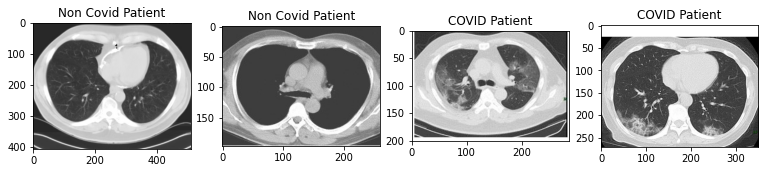

In [ ]:
f = plt.figure(figsize=(13, 10))
f.add_subplot(1, 4, 1)
Plot_Image(35,False)
f.add_subplot(1,4, 2)
Plot_Image(34,False)
f.add_subplot(1,4, 3)
Plot_Image(18,True)
f.add_subplot(1,4, 4)
Plot_Image(54,True)
### the images are not necessarily all the same size

In [ ]:
dimensions = []
for p in os.listdir('CT_COVID/'):
  img=str(pathlib.Path().absolute())+str('/CT_COVID/')+p
  img= cv2.imread(img)
  dimensions.append({'Width': img.shape[:-1][0],'Height': img.shape[:-1][1],})
dimensions=pd.DataFrame(dimensions)
dimensions2=[]
for p in os.listdir('CT_NonCOVID/'):
  img=str(pathlib.Path().absolute())+str('/CT_NonCOVID/')+p
  img= cv2.imread(img)
  dimensions2.append({'Width': img.shape[:-1][0],'Height': img.shape[:-1][1],})
dimensions2=pd.DataFrame(dimensions2)

### combining 
dimensions=pd.concat([dimensions,dimensions2])

In [ ]:
dimensions.describe()

,Width,Height
count,746.000000,746.000000
mean,302.553619,425.482574
std,145.210573,188.546038
min,61.000000,115.000000
25%,204.000000,311.250000
50%,291.000000,407.000000
75%,363.750000,512.000000
max,1225.000000,1671.000000


In [ ]:
## Dataframe of labels and images including the full path to the image
Covid_Cases=pd.DataFrame((os.listdir('CT_COVID')))
Covid_Cases.columns=['imgPath']
Covid_Cases['imgPath']=str(pathlib.Path().absolute())+str('/CT_COVID/')+Covid_Cases['imgPath']
Covid_Cases['Label']=1
Non_Covid=pd.DataFrame((os.listdir('CT_NonCOVID')))
Non_Covid.columns=['imgPath']
Non_Covid['imgPath']=str(pathlib.Path().absolute())+str('/CT_NonCOVID/')+Non_Covid['imgPath']
Non_Covid['Label']=0
# combining to one dataframe 0 for non covid 1 for covid
Combined=pd.concat([Covid_Cases,Non_Covid],axis=0)
Combined.head()

,imgPath,Label
0,/content/gdrive/My Drive/Kaggle/CT_COVID/2020....,1
1,/content/gdrive/My Drive/Kaggle/CT_COVID/2020....,1
2,/content/gdrive/My Drive/Kaggle/CT_COVID/2020....,1
3,/content/gdrive/My Drive/Kaggle/CT_COVID/2020....,1
4,/content/gdrive/My Drive/Kaggle/CT_COVID/2020....,1


In [ ]:
Combined['Label'].value_counts() # 1 for covid 

0    397
1    349
Name: Label, dtype: int64

In [ ]:
## checking some of the image readers
to_tensor=T.ToTensor()
print(to_tensor(cv2.imread(Combined.iloc[2,0])).size())
print(to_tensor(Image.open(Combined.iloc[2,0]).convert("RGB")).size()) ## .convert rgb to get same channels

torch.Size([3, 202, 287])
torch.Size([3, 202, 287])


In [ ]:
## getting training and test data
train, test = train_test_split(Combined, stratify=Combined['Label'], test_size=0.2 ,random_state=1)
print(train['Label'].value_counts())
print(test['Label'].value_counts())

0    317
1    279
Name: Label, dtype: int64
0    80
1    70
Name: Label, dtype: int64


In [ ]:
## pytorch preprocessing format with dataset 
class CTData(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img,label = self.data[index]
        image = Image.open(img).convert("RGB")
        label=torch.tensor(label)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
## transforms 
train_transform = T.Compose(
        [
            T.Resize((150, 150)),
            T.RandomCrop((140, 140)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
test_transform = T.Compose(
        [
            T.Resize((150, 150)),
            T.RandomCrop((140, 140)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [ ]:
## tranforming on train and test data 
train_data = CTData(train,train_transform )
test_data=CTData(test,test_transform)

In [ ]:
## using the DataLoader 
train_loader = DataLoader(dataset = train_data, batch_size = 25, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size = 25)

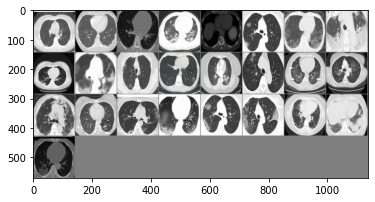

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images of the batch size
imshow(torchvision.utils.make_grid(images))

In [ ]:
single_batch = next(iter(train_loader))
print("Single batch shape: ", single_batch[0].shape)
print("\nOutput label tensors and Size: ", single_batch[1],single_batch[1].shape)

Single batch shape:  torch.Size([25, 3, 140, 140])

Output label tensors and Size:  tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0]) torch.Size([25])


**3. Modeling with various Neural networks architectures**
1. basic architecure with more/less channels and  Resnet architecture
2. Hyperparameter tuning with K fold get best learning rate for each loss (crossEntropy and cosine loss) 
3. Comparison of AUC from using cosine vs crossentropy loss with optimized hyperparameters. Overall try to obtain highest AUC on test set



3.1 Training functions
  - cos los
  - standard

In [ ]:
## checking if cuda is avaiable
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# stadard training
def training_loop(num_epochs,optimizer,model,loss_fn,train_loader):
  for epoch in range(1,num_epochs+1):
    loss_train=0
    for imgs, labels in train_loader:
      imgs=imgs.to(device=device)
      labels=labels.to(device=device)
      outputs=model(imgs)
      loss=loss_fn(outputs,labels)
      optimizer.zero_grad()
      loss.backward() # backward pass
      optimizer.step() # update model
      loss_train+=loss.item() ## sum losses over the epoch
    if epoch==1 or epoch %5==0:
      print('Epoch {} Training loss {}'.format(epoch,loss_train/len(train_loader)))## average loss per batch 

In [ ]:
def training_loop_Cos(num_epochs,optimizer,model,loss_fn,train_loader):
  for epoch in range(1,num_epochs+1):
    loss_train=0
    for imgs, labels in train_loader:
      labels=torch.tensor(np.where(labels==1,1,-1))
      imgs=imgs.to(device=device)
      labels=labels.to(device=device)
      outputs=model(imgs)
      loss=loss_fn(outputs[:,1], labels)
      loss=1-loss
      optimizer.zero_grad()
      loss.backward() # backward pass
      optimizer.step() # update model
      loss_train+=loss.item() ## sum losses over the epoch
    if epoch==1 or epoch %5==0:
      print('Epoch {} Training loss {}'.format(epoch,loss_train/len(train_loader)))## average loss per batch 

3.2 Performance Metrics
  - Accuracy
  - AUC

In [ ]:
## returns accuracy for any model that is made 
def get_accuracy(model,train_loader,test_loader):
  torch.manual_seed(1)
  train_test = []
  for name,loader in [('train',train_loader), ("test",test_loader)]:
    correct=0
    total=0
    with torch.no_grad():
      for imgs,labels in loader:
        imgs=imgs.to(device=device)
        labels=labels.to(device=device)
        outputs=model(imgs)## getting the outputs returns 2 values per image reprensenting raw logits
        _,predicted=torch.max(outputs,dim=1) ## getting the prediction returns shape 25 tensor for 0 or 1 _ returns value of ouputs
        total+=labels.shape[0]##tallying the total number of possible predictions
        correct+=int((predicted==labels).sum()) ## outputs[:,1] is how to access probality of being covid
    print("Accuracy {}: {:.2f}".format(name,correct/total))
    train_test.append(correct/total)
  return train_test

## returns training AUC score
def get_train_auc(model,train_loader):
    torch.manual_seed(1)
    prob_class=[] ## for storing predicted probablities
    Actual_Class=[]# for storing the actual class
    for name,loader in [('train',train_loader)]:
      with torch.no_grad():
        for imgs,labels in loader:
          imgs=imgs.to(device=device)
          labels=labels.to(device=device)
          outputs=model(imgs)## getting the outputs returns 2 values per image reprensenting raw logits
          outputs=F.softmax(outputs,dim=1) ## converting to probalities for AUC
          _,predicted=torch.max(outputs,dim=1) ## getting the prediction returns shape 25 tensor for 0 or 1 _ returns value of ouputs
          outputs=outputs.cpu().numpy()
          labels=labels.cpu().numpy()
          prob_class.append(outputs[:,1]) # probabilities 
          Actual_Class.append(labels) # actual predictions
    auc_score=roc_auc_score(np.concatenate(Actual_Class,axis=None),np.concatenate(prob_class,axis=None))
    print("AUC train {}".format(auc_score)) 
    return auc_score

## returns testing AUC for any model made
def get_test_auc(model,test_loader):
    torch.manual_seed(1)
    prob_class=[] ## for storing predicted probablities
    Actual_Class=[]# for storing the actual class
    for name,loader in [('test',test_loader)]:
      with torch.no_grad():
        for imgs,labels in loader:
          imgs=imgs.to(device=device)
          labels=labels.to(device=device)
          outputs=model(imgs)## getting the outputs returns 2 values per image reprensenting raw logits
          outputs=F.softmax(outputs,dim=1) ## converting to probalities for AUC
          _,predicted=torch.max(outputs,dim=1) ## getting the prediction returns shape 25 tensor for 0 or 1 _ returns value of ouputs
          outputs=outputs.cpu().numpy()
          labels=labels.cpu().numpy()
          prob_class.append(outputs[:,1]) # probabilities 
          Actual_Class.append(labels) # actual predictions
    auc_score=roc_auc_score(np.concatenate(Actual_Class,axis=None),np.concatenate(prob_class,axis=None))
    print("AUC test {}".format(auc_score)) 
    return auc_score

## returns probabilties assigned per test sample for any model made and plots them
def get_test_ProbaPlot(model,test_loader):
    torch.manual_seed(1)
    prob_class=[] ## for storing predicted probablities
    Actual_Class=[]# for storing the actual class
    for name,loader in [('test',test_loader)]:
      with torch.no_grad():
        for imgs,labels in loader:
          imgs=imgs.to(device=device)
          labels=labels.to(device=device)
          outputs=model(imgs)## getting the outputs returns 2 values per image reprensenting raw logits
          outputs=F.softmax(outputs,dim=1) ## converting to probalities for AUC
          _,predicted=torch.max(outputs,dim=1) ## getting the prediction returns shape 25 tensor for 0 or 1 _ returns value of ouputs
          outputs=outputs.cpu().numpy()
          labels=labels.cpu().numpy()
          prob_class.append(outputs[:,1]) # probabilities 
          Actual_Class.append(labels) # actual predictions
    actual=np.concatenate((Actual_Class),axis=None)
    prob=np.concatenate((prob_class),axis=None)
    auc_score=roc_auc_score(actual,prob)
    plt.figure(figsize=(16,4))
    label=['Covid','Not Covid']
    plt.scatter(prob,np.zeros(len(actual)),c=actual,alpha=.6,s=100)
    plt.axvline(.5,c='black',linestyle='dashed')
    plt.xlabel("Probability")
    plt.title("AUC=%.2f" %auc_score)     

## gets accuracy at any threshold, where threshold is the prob. cutoff for classifying an image covid
def get_accuracy_threshold(model,train_loader,test_loader,threshold):
  torch.manual_seed(1)
  train_test = []
  for name,loader in [('train',train_loader), ("test",test_loader)]:
    correct=0
    total=0
    with torch.no_grad():
      for imgs,labels in loader:
        imgs=imgs.to(device=device)
        labels=labels.to(device=device)
        outputs=model(imgs)## getting the outputs returns 2 values per image reprensenting raw logits
        outputs=F.softmax(outputs,dim=1)
        predicted=torch.where(outputs[:,1]>threshold,1,0)
        total+=labels.shape[0]##tallying the total number of possible predictions
        correct+=int((predicted==labels).sum()) ## outputs[:,1] is how to access probality of being covid
    print("Accuracy {}: {:.2f}".format(name,correct/total))
    train_test.append(correct/total)
  return train_test 

3.3 Architecture 
  - Simple archtecture 
  - Resnet 


In [ ]:
## the point of this one is to adjust n_chans1 to see if it can compensate for being simple by increasing n_chans1
class BasicNetV2(nn.Module):
  def __init__(self,n_chans1=32):
    super().__init__()
    self.n_chans1=n_chans1
    self.conv1=nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(n_chans1,n_chans1//2,kernel_size=3,padding=1)
    self.fc1=nn.Linear((n_chans1//2)*35*35,32) ## must be 16*35*35
    self.fc2=nn.Linear(32,2) 
  def forward(self,x):
    out=F.max_pool2d(torch.relu(self.conv1(x)),2)
    out=F.max_pool2d(torch.relu(self.conv2(out)),2)
    out=out.view(-1,(self.n_chans1//2)*35*35)
    out=torch.relu(self.fc1(out))
    out=self.fc2(out)
    return out

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)
  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

class ResNet(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=8):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
    self.fc1 = nn.Linear(35 * 35 * n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1,35*35* self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

3.4 Model Evaluation 
- Kfold to find optimal learning rate for each loss on each Architecture
- Performance on test set

In [ ]:
def BasicNetcv(nsplits,lrRate,loss_function,epochs):
  '''
  performs k fold for the basic net architecture
  lrRate- input a list of learning rates to try
  nsplits= number of K fold to do( 3 fold...)
  loss function- either 'CrossEntropy' or 'Cosine'
  epochs-num epochs to use on the training folds
  
  Outputs: AUC of the test folds (Mean, sd, and learning rate used)
    '''
  Net=BasicNetV2(32).to(device=device)
  AUC=[]
  ## K fold splitting the training dataframe made previously
  for trainidx,testidx in KFold(nsplits).split(train):
    dat_train = train.iloc[trainidx]
    dat_test=train.iloc[testidx]
    # converting it to the pytroch data performing usual operations into data loader
    dat_train=CTData(dat_train,train_transform)
    dat_test=CTData(dat_test,test_transform)
    train_loadercv = DataLoader(dataset = dat_train, batch_size = 20, shuffle=True)
    test_loadercv = DataLoader(dataset = dat_test, batch_size = 20)
    ## now getting model 
    optimizer = torch.optim.Adam(Net.parameters(),lr=lrRate)
    ## running training loop 
    if loss_function == 'CrossEntropy':
      training_loop(num_epochs=epochs,optimizer=optimizer,model=Net,loss_fn=nn.CrossEntropyLoss(),train_loader=train_loadercv)

    else:
      training_loop_Cos(num_epochs=epochs,optimizer=optimizer,model=Net,loss_fn=nn.CosineSimilarity(dim=0),train_loader=train_loadercv)

    AUC.append(get_test_auc(Net,test_loadercv))
    Net=BasicNetV2(32).to(device=device)
  return np.mean(AUC),np.std(AUC),lrRate
    

In [ ]:
BasicNetcv(3,1e-3,'Cosine',60) 

Epoch 1 Training loss 0.6813101232051849
Epoch 5 Training loss 0.37674614787101746
Epoch 10 Training loss 0.2645889103412628
Epoch 15 Training loss 0.16374749839305877
Epoch 20 Training loss 0.10340170562267303
Epoch 25 Training loss 0.07014037072658538
Epoch 30 Training loss 0.05090450644493103
Epoch 35 Training loss 0.04090265929698944
Epoch 40 Training loss 0.02696477174758911
Epoch 45 Training loss 0.021825885772705077
Epoch 50 Training loss 0.031081891059875487
Epoch 55 Training loss 0.025787052512168885
Epoch 60 Training loss 0.021413528919219972
AUC test 0.8863636363636364
Epoch 1 Training loss 0.9914740562438965
Epoch 5 Training loss 0.5171169012784957
Epoch 10 Training loss 0.40660074949264524
Epoch 15 Training loss 0.3224317729473114
Epoch 20 Training loss 0.23591980636119841
Epoch 25 Training loss 0.24774944186210632
Epoch 30 Training loss 0.20101273357868193
Epoch 35 Training loss 0.17580171525478364
Epoch 40 Training loss 0.15928685665130615
Epoch 45 Training loss 0.119451

(0.868560606060606, 0.06024751899071256, 0.001)

In [ ]:
## cosine loss
## now retraining on all the training data
BasicNetV2=BasicNetV2(32).to(device=device)
optimizer = torch.optim.Adam(BasicNetV2.parameters(),lr=1e-3)
training_loop_Cos(num_epochs=110,optimizer=optimizer,model=BasicNetV2,loss_fn=nn.CosineSimilarity(dim=0),train_loader=train_loader)

Epoch 1 Training loss 0.912425530453523
Epoch 5 Training loss 0.5356741473078728
Epoch 10 Training loss 0.29253437618414563
Epoch 15 Training loss 0.19414919366439184
Epoch 20 Training loss 0.17363333453734717
Epoch 25 Training loss 0.12269434084494908
Epoch 30 Training loss 0.08933461457490921
Epoch 35 Training loss 0.09910086790720622
Epoch 40 Training loss 0.05240168422460556
Epoch 45 Training loss 0.04660186171531677
Epoch 50 Training loss 0.03560815006494522
Epoch 55 Training loss 0.03186079363028208
Epoch 60 Training loss 0.031402505934238434
Epoch 65 Training loss 0.032779778043429054
Epoch 70 Training loss 0.024151782194773357
Epoch 75 Training loss 0.0205769216020902
Epoch 80 Training loss 0.021196347971757252
Epoch 85 Training loss 0.024015463888645172
Epoch 90 Training loss 0.020484164357185364
Epoch 95 Training loss 0.02411479502916336
Epoch 100 Training loss 0.0174062376221021


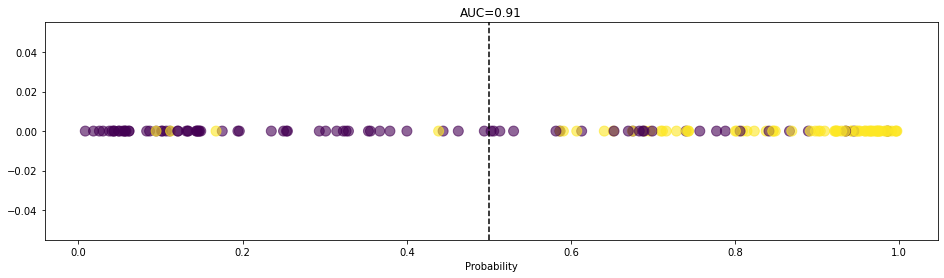

In [ ]:
get_test_ProbaPlot(BasicNetV2,test_loader) ## cosine loss, yellow are covid images purple are not

In [ ]:
axis_labels = []#Set up these lists to add the results to, from here if one of the final performance blocks is ran multiple times it will show up in the table that many times
train_acc = []
test_acc = []
train_auc = []
test_auc = []

In [ ]:
## basicnet performance with cosine on test data set
axis_labels.append("BasicNetV2 (Cosine)")

acc = get_accuracy(BasicNetV2,train_loader,test_loader)  
train_auc.append(get_train_auc(BasicNetV2,train_loader))
test_auc.append(get_test_auc(BasicNetV2,test_loader)) 

train_acc.append(acc[0])
test_acc.append(acc[1])


Accuracy train: 0.99
Accuracy test: 0.77
AUC train 0.9999321596960754
AUC test 0.9073214285714286


In [ ]:
BasicNetcv(3,1e-3,'CrossEntropy',120) 

Epoch 1 Training loss 0.7219524621963501
Epoch 5 Training loss 0.5951183527708054
Epoch 10 Training loss 0.47017144560813906
Epoch 15 Training loss 0.3466403163969517
Epoch 20 Training loss 0.23125202357769012
Epoch 25 Training loss 0.20363150388002396
Epoch 30 Training loss 0.1778279879130423
Epoch 35 Training loss 0.14833996761590243
Epoch 40 Training loss 0.09404614735394716
Epoch 45 Training loss 0.08473387298872695
Epoch 50 Training loss 0.0826692492235452
Epoch 55 Training loss 0.08271667056251317
Epoch 60 Training loss 0.07764529946725815
Epoch 65 Training loss 0.044869605160783976
Epoch 70 Training loss 0.03602506220340729
Epoch 75 Training loss 0.05200032871216535
Epoch 80 Training loss 0.023843600483087358
Epoch 85 Training loss 0.02703725685423706
Epoch 90 Training loss 0.025937112752581017
Epoch 95 Training loss 0.038386420428287236
Epoch 100 Training loss 0.034378133535210506
Epoch 105 Training loss 0.05528109130973462
Epoch 110 Training loss 0.05587695179856382
Epoch 115 

(0.8510414977932882, 0.005589922984176387, 0.001)

In [ ]:
## now with cross entropy loss 
## retraining the network to all the training data 
BasicNetV2=BasicNetV2(32).to(device=device)
optimizer = torch.optim.Adam(BasicNetV2.parameters(),lr=1e-3)
training_loop(num_epochs=110,optimizer=optimizer,model=BasicNetV2,loss_fn=nn.CrossEntropyLoss(),train_loader=train_loader)

Epoch 1 Training loss 0.731726236641407
Epoch 5 Training loss 0.5131423150499662
Epoch 10 Training loss 0.41740502417087555
Epoch 15 Training loss 0.39272057948013145
Epoch 20 Training loss 0.2731342116991679
Epoch 25 Training loss 0.2726527014747262
Epoch 30 Training loss 0.20613632692644993
Epoch 35 Training loss 0.19949358701705933
Epoch 40 Training loss 0.14152619250429174
Epoch 45 Training loss 0.12697576661594212
Epoch 50 Training loss 0.1376746875078728
Epoch 55 Training loss 0.09022611984983087
Epoch 60 Training loss 0.1319762479591494
Epoch 65 Training loss 0.07868267650095125
Epoch 70 Training loss 0.07415606514162694
Epoch 75 Training loss 0.06526968500111252
Epoch 80 Training loss 0.0649707675523435
Epoch 85 Training loss 0.05246164343164613
Epoch 90 Training loss 0.04592941187244529
Epoch 95 Training loss 0.06930505204945803
Epoch 100 Training loss 0.03581830480349405


In [ ]:
axis_labels.append("BasicNetV2 (Cross Entropy)")
## basicnet performance with cross entropy on test data set # their is also high variation in our test sets from random splits
acc = get_accuracy(BasicNetV2,train_loader,test_loader)  
train_auc.append(get_train_auc(BasicNetV2,train_loader))
test_auc.append(get_test_auc(BasicNetV2,test_loader))

train_acc.append(acc[0])
test_acc.append(acc[1])

Accuracy train: 0.97
Accuracy test: 0.70
AUC train 0.9989258618545277
AUC test 0.8527678571428572


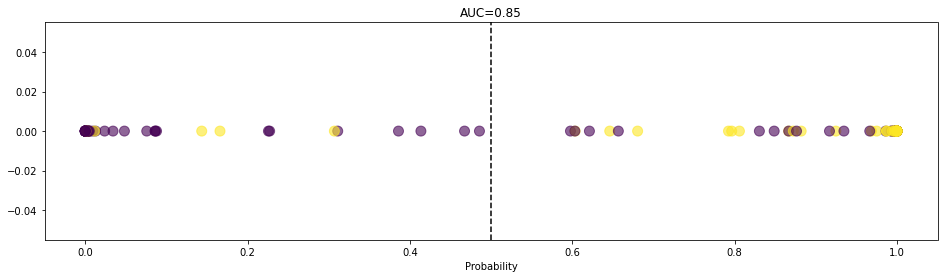

In [ ]:
get_test_ProbaPlot(BasicNetV2,test_loader) ## Cross Entropy

In [ ]:
def ResNetcv(nsplits,lrRate,loss_function,epochs):
  '''
  lrRates- input learning rate to try
  nsplits= number of K fold to do( 3 fold...)
  loss function- either crossentropy loss or cosine input 'CrossEntropy' or 'Cosine'

  Outputs: AUC of the test folds (Mean, sd, and learning rate used)
    '''
  Net=ResNet(32).to(device=device)
  AUC=[]
  ## K fold splitting the training dataframe made previously
  for trainidx,testidx in KFold(nsplits).split(train):
    dat_train = train.iloc[trainidx]
    dat_test=train.iloc[testidx]
    # converting it to the pytroch data performing usual operations into data loader
    dat_train=CTData(dat_train,train_transform)
    dat_test=CTData(dat_test,test_transform)
    train_loadercv = DataLoader(dataset = dat_train, batch_size = 20, shuffle=True)
    test_loadercv = DataLoader(dataset = dat_test, batch_size = 20)
    ## now getting model 
    optimizer = torch.optim.Adam(Net.parameters(),lr=lrRate)
    ## running training loop 
    if loss_function == 'CrossEntropy':
      training_loop(num_epochs=epochs,optimizer=optimizer,model=Net,loss_fn=nn.CrossEntropyLoss(),train_loader=train_loadercv)
    else:
      training_loop_Cos(num_epochs=epochs,optimizer=optimizer,model=Net,loss_fn=nn.CosineSimilarity(dim=0),train_loader=train_loadercv)


    AUC.append(get_test_auc(Net,test_loadercv))
    Net=ResNet(32).to(device=device)
  return np.mean(AUC),np.std(AUC),lrRate
    

In [ ]:
ResNetcv(3,1e-3,'Cosine',90)

Epoch 1 Training loss 0.7922096431255341
Epoch 5 Training loss 0.4975438892841339
Epoch 10 Training loss 0.3939098984003067
Epoch 15 Training loss 0.48166661262512206
Epoch 20 Training loss 0.22366078197956085
Epoch 25 Training loss 0.18772077262401582
Epoch 30 Training loss 0.18965404033660888
Epoch 35 Training loss 0.12021586000919342
Epoch 40 Training loss 0.10787091255187989
Epoch 45 Training loss 0.06989493072032929
Epoch 50 Training loss 0.11674108505249023
Epoch 55 Training loss 0.08574166297912597
Epoch 60 Training loss 0.08158464133739471
Epoch 65 Training loss 0.06275674998760224
Epoch 70 Training loss 0.06400251686573029
Epoch 75 Training loss 0.06982750296592713
Epoch 80 Training loss 0.08115456700325012
Epoch 85 Training loss 0.04055604040622711
Epoch 90 Training loss 0.0319129079580307
AUC test 0.8526683343756515
Epoch 1 Training loss 0.7493221282958984
Epoch 5 Training loss 0.37182390689849854
Epoch 10 Training loss 0.2962752997875214
Epoch 15 Training loss 0.23331946730

(0.7964065806046307, 0.049356060659446914, 0.001)

In [ ]:
# cosine
Resnet=ResNet(32).to(device=device)
optimizer = torch.optim.Adam(Resnet.parameters(),lr=1e-4)
training_loop_Cos(num_epochs=200,optimizer=optimizer,model=Resnet,loss_fn=nn.CosineSimilarity(dim=0),train_loader=train_loader)

Epoch 1 Training loss 1.0247509156664212
Epoch 5 Training loss 0.42343488583962124
Epoch 10 Training loss 0.28250205268462497
Epoch 15 Training loss 0.2478622868657112
Epoch 20 Training loss 0.20739696671565375
Epoch 25 Training loss 0.1611568753918012
Epoch 30 Training loss 0.13885554174582163
Epoch 35 Training loss 0.1265245129664739
Epoch 40 Training loss 0.14801930636167526
Epoch 45 Training loss 0.09252386540174484
Epoch 50 Training loss 0.0960450991988182
Epoch 55 Training loss 0.10997944821914037
Epoch 60 Training loss 0.06860585014025371
Epoch 65 Training loss 0.050727558632691704
Epoch 70 Training loss 0.07687993099292119
Epoch 75 Training loss 0.0722219745318095
Epoch 80 Training loss 0.0496284564336141
Epoch 85 Training loss 0.05525698264439901
Epoch 90 Training loss 0.0379203533132871
Epoch 95 Training loss 0.031617109974225364
Epoch 100 Training loss 0.03907326112190882
Epoch 105 Training loss 0.042694397270679474
Epoch 110 Training loss 0.03594372421503067
Epoch 115 Train

In [ ]:
axis_labels.append("Resnet (Cosine)")
acc = get_accuracy(Resnet,train_loader,test_loader)  
train_auc.append(get_train_auc(Resnet,train_loader))
test_auc.append(get_test_auc(Resnet,test_loader))

train_acc.append(acc[0])
test_acc.append(acc[1])

Accuracy train: 0.78
Accuracy test: 0.65
AUC train 0.9984962065963389
AUC test 0.8579464285714286


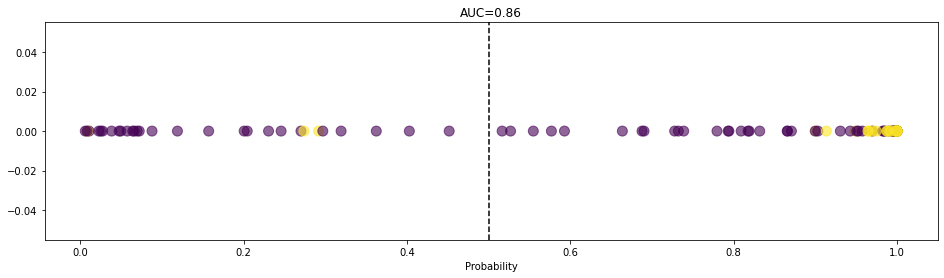

In [ ]:
get_test_ProbaPlot(Resnet,test_loader) ## interesting with this resnet the probability threshold could be moved to 
# around 90% where only images that are greater than 90% probability of covid are classified as covid and accuracy 
#would be in the 80's probably
#(e.g by moving the dashed vertical line below to the right and saying everything left of it is not covid)

In [ ]:
get_accuracy_threshold(Resnet,train_loader,test_loader,.95)  ## accuracy now 79% at 95% classification threshold

Accuracy train: 0.96
Accuracy test: 0.79


[0.9580536912751678, 0.7866666666666666]

In [ ]:
ResNetcv(3,1e-3,'CrossEntropy',80)

Epoch 1 Training loss 7.869089287519455
Epoch 5 Training loss 1.3277872033417224
Epoch 10 Training loss 0.6349173560738564
Epoch 15 Training loss 0.4539338558912277
Epoch 20 Training loss 0.6391242014244198
Epoch 25 Training loss 0.16819297857582569
Epoch 30 Training loss 0.29176915092393757
Epoch 35 Training loss 0.2851317313266918
Epoch 40 Training loss 0.1450041032396257
Epoch 45 Training loss 0.1410496151074767
Epoch 50 Training loss 0.08564072111621499
Epoch 55 Training loss 0.12758588404394686
Epoch 60 Training loss 0.2093760654097423
Epoch 65 Training loss 0.08228274073917419
Epoch 70 Training loss 0.1259034274960868
Epoch 75 Training loss 0.13195043778978288
Epoch 80 Training loss 0.05367224286310375
AUC test 0.8829476756306024
Epoch 1 Training loss 9.385093092918396
Epoch 5 Training loss 0.593676307797432
Epoch 10 Training loss 0.5108097724616527
Epoch 15 Training loss 0.5566540241241456
Epoch 20 Training loss 0.3127668686211109
Epoch 25 Training loss 0.3014079533517361
Epoch 

(0.8702445847099624, 0.024007084979772955, 0.001)

In [ ]:
## refitting resnet to all the training data 
Resnet=ResNet(32).to(device=device)
optimizer = torch.optim.Adam(Resnet.parameters(),lr=1e-4)
training_loop(num_epochs=200,optimizer=optimizer,model=Resnet,loss_fn=nn.CrossEntropyLoss(),train_loader=train_loader)

Epoch 1 Training loss 0.9807057579358419
Epoch 5 Training loss 0.5680966998140017
Epoch 10 Training loss 0.5212147422134876
Epoch 15 Training loss 0.48798155784606934
Epoch 20 Training loss 0.4753525530298551
Epoch 25 Training loss 0.43727894127368927
Epoch 30 Training loss 0.41475524629155797
Epoch 35 Training loss 0.40351665516694385
Epoch 40 Training loss 0.39032871772845584
Epoch 45 Training loss 0.3736030136545499
Epoch 50 Training loss 0.3621414514879386
Epoch 55 Training loss 0.35946650989353657
Epoch 60 Training loss 0.3374848322321971
Epoch 65 Training loss 0.31522713601589203
Epoch 70 Training loss 0.3249790749202172
Epoch 75 Training loss 0.3071015098442634
Epoch 80 Training loss 0.2958376177897056
Epoch 85 Training loss 0.30100200201074284
Epoch 90 Training loss 0.3041859728594621
Epoch 95 Training loss 0.28241981007158756
Epoch 100 Training loss 0.27600389656921226
Epoch 105 Training loss 0.2735399504502614
Epoch 110 Training loss 0.2722064846505721
Epoch 115 Training loss

In [ ]:
axis_labels.append("Resnet (Cross Entropy)")
acc = get_accuracy(Resnet,train_loader,test_loader)  
train_auc.append(get_train_auc(Resnet,train_loader))
test_auc.append(get_test_auc(Resnet,test_loader))

train_acc.append(acc[0])
test_acc.append(acc[1])

Accuracy train: 0.97
Accuracy test: 0.86
AUC train 0.9819262123627648
AUC test 0.887142857142857


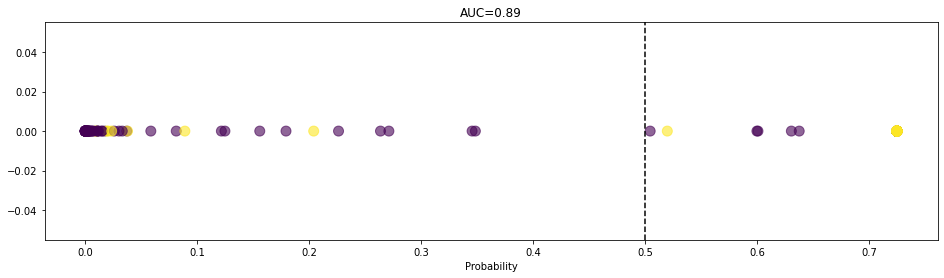

In [ ]:
get_test_ProbaPlot(Resnet,test_loader) ## odd it seems to be giving exactly 75ish% probabilitiy to alot of covid+ images

In [ ]:
get_accuracy_threshold(Resnet,train_loader,test_loader,.7) 

Accuracy train: 0.97
Accuracy test: 0.89


[0.9664429530201343, 0.8866666666666667]

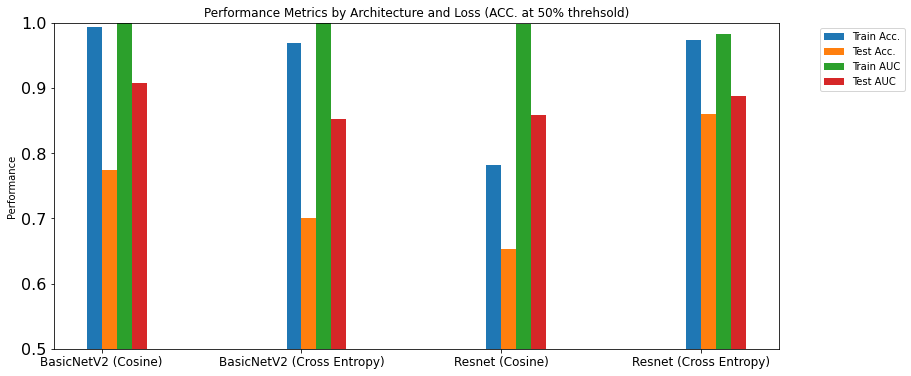

In [ ]:
N = 4
ind = np.arange(N)
width = 0.075
plt.figure(figsize=(13,6))
plt.bar(ind, train_acc, width, label='Train Acc.')
plt.bar(ind+width, test_acc, width, label='Test Acc.')
plt.bar(ind+2*width, train_auc, width, label='Train AUC')
plt.bar(ind+3*width, test_auc, width, label='Test AUC')
plt.ylabel('Performance')
plt.ylim([0.5, 1])
plt.title('Performance Metrics by Architecture and Loss (ACC. at 50% threhsold)')

plt.xticks(ind+width/2, axis_labels)
plt.legend(bbox_to_anchor=(1.05, 1))

plt.tick_params(axis='x', which='major', labelsize=12)
plt.show()

## so by AUC basicNET cosine is the best but Resnet Cross entropy has much fewer false negatives and higher acc at 50%, so
# perhaps it is better but odd in the way it assigns probability 
# also I set the random_state for the train test split 
# so this should be reproducable. 